In [1]:
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import mne

In [4]:
import pandas as pd

In [5]:
from scipy.io import loadmat

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [9]:
from sklearn.decomposition import PCA

In [11]:
MAIN_CHANNELS = ["Fz", "Cz", "P3", "Pz", "P4", "Po7", "Po8", "Oz"]

In [25]:
sfreq = 250

In [26]:
def load_data(subject):
    channels = MAIN_CHANNELS
    
    session = loadmat('data/{}.mat'.format(subject))

    session_df = pd.DataFrame(session["y"], columns=channels)

    sfreq = session["fs"][0][0]

    session_df["Time"] = session_df.index / session["fs"][0][0]

    session_df["Trigger"] = session["trig"]
    session_df.loc[session_df["Trigger"] == -1, "Trigger"] = 2
    
    return session_df

In [27]:
def restore_raw(session_df):
    channels = MAIN_CHANNELS + ['Trigger']
    info = mne.create_info(ch_names=channels, sfreq=sfreq)

    raw = mne.io.RawArray(session_df[channels].values.T, info)

    channel_types = {c: 'eeg' for c in channels}
    channel_types['Trigger'] = 'stim'

    raw.set_channel_types(channel_types)
    
    return raw

In [28]:
def filter_signal(raw):
    raw.notch_filter(50)
    raw.filter(0.5, 30)

In [29]:
def plot_raw(raw, start=0, stop=240, scale=100):
    rcParams['figure.figsize'] = 20, 10
    mne.viz.plot_raw(
        raw, 
        start=start, 
        duration=stop - start, 
        show=False, 
        n_channels=8,
        scalings={'eeg': scale}
    )
    plt.show()

In [57]:
def scale_signal(raw, session_df):
    channels = MAIN_CHANNELS + ['Trigger']
    
    channels_data = raw.copy().pick_types(eeg=True).get_data()

    trigger_data = session_df["Trigger"].values

    scaler = StandardScaler()

    scaled_channels_data = scaler.fit_transform(channels_data.T).T

    np.mean(scaled_channels_data, axis=1)

    new_channels_data = np.vstack([
        scaled_channels_data,
        trigger_data[np.newaxis, :]
    ])

    raw = mne.io.RawArray(new_channels_data, raw.info)
    
    channel_types = {c: 'eeg' for c in channels}
    channel_types['Trigger'] = 'stim'

    raw.set_channel_types(channel_types)
    
    return raw

In [58]:
def remove_artifacts(raw):
    ica = mne.preprocessing.ICA()

    ica.fit(raw)

    ica_eeg = ica.get_sources(raw)

    plt.figure(figsize=(10, 5))
    plt.plot(ica_eeg[:, :][0].T + 10 * np.arange(0, 8))

    stds = np.std(np.abs(ica_eeg[:, :][0]), axis=1)
    exclude_components = (-stds).argsort()[0:3]

    raw = ica.apply(raw.copy(), exclude=list(exclude_components))
    
    return raw

In [59]:
def get_epochs(raw):
    events = mne.find_events(raw, 'Trigger')
    
    epochs = mne.Epochs(
        raw.pick_types(eeg=True), 
        events, tmin=-0.1, tmax=0.7,
        reject_by_annotation=False,
        preload=True
    )
#     epochs = epochs.apply_baseline((-0.1, 0))
    return epochs

In [60]:
def show_p300_plots(epochs):
    epochs['1'].average().plot()
    plt.show()
    
    epochs['2'].average().plot()
    plt.show()

In [61]:
from tqdm import tqdm_notebook

In [103]:
def extract_features(subject, epochs):
    time = np.arange(0, 201) * 4 - 100
    sigma = 50
    p300_gaussian = 1 / (2 * np.pi * sigma) * np.e ** (-(time - 300) ** 2 / sigma ** 2)
    sliding_window_size = 10
    
    features = []
    
    for i in tqdm_notebook(range(sliding_window_size, 150)):
        p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
    
        latency = np.argmax(p300_matrix.mean(axis=0) * p300_gaussian)

        amplitude = p300_matrix[:, max(latency - 5, 0):latency + 5].mean(axis=1).mean()

#         plt.figure(figsize=(10, 5))
#         plt.plot(time, p300_matrix.mean(axis=0) * p300_gaussian) 

        features.append((latency * 4 - 100, amplitude, subject, i))
        
    return features

In [104]:
def process_signal(i, features_extraction=True):
    subject = "S{}".format(i)
    session_df = load_data(subject)
    raw = restore_raw(session_df)
    plot_raw(raw)
    
    filter_signal(raw)
    raw = remove_artifacts(raw)
    raw = scale_signal(raw, session_df)
    
    plot_raw(raw, scale=10)
    
    epochs = get_epochs(raw)    
    show_p300_plots(epochs)
    
    if features_extraction:
        return extract_features(subject, epochs)
    else:
        return epochs

Creating RawArray with float64 data, n_channels=9, n_times=65282
    Range : 0 ... 65281 =      0.000 ...   261.124 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


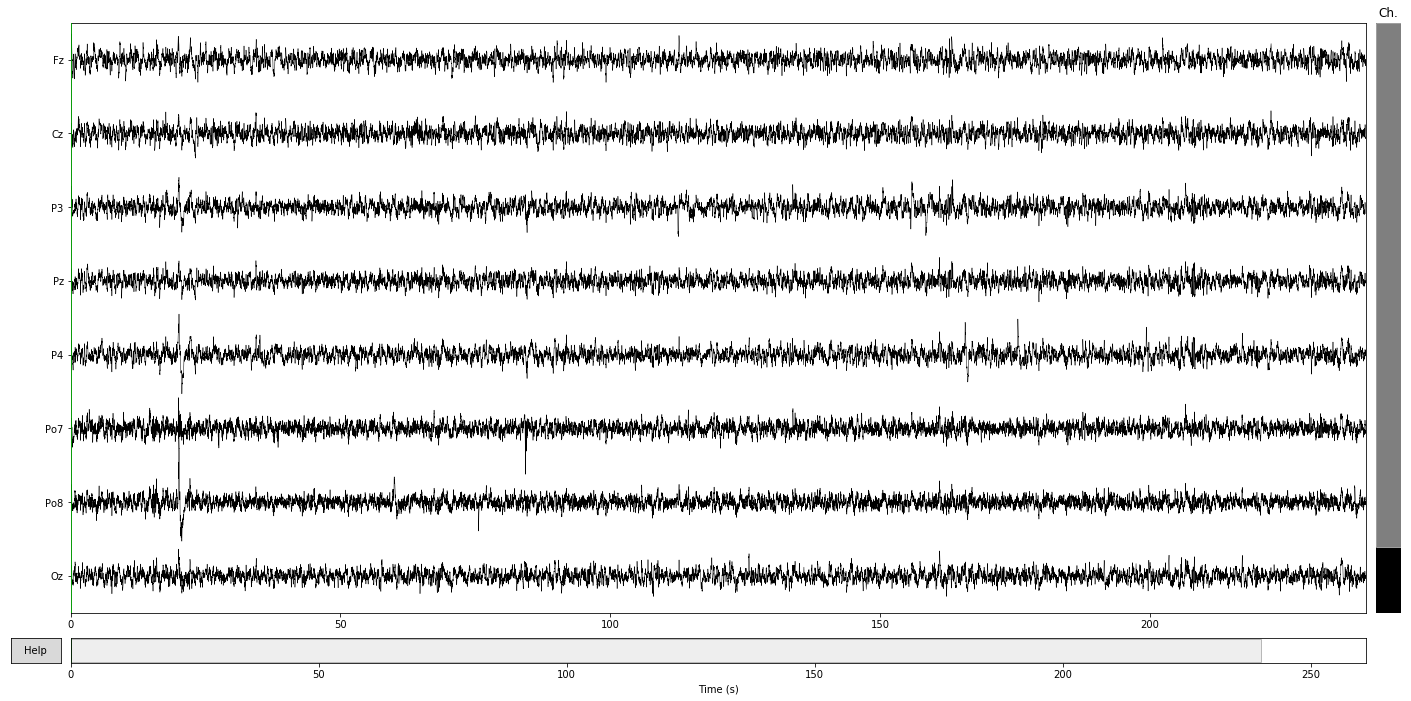

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.4s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=65282
    Range : 0 ... 65281 =      0.000 ...   261.124 secs
Ready.


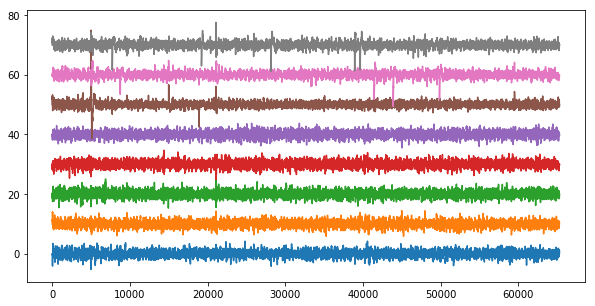

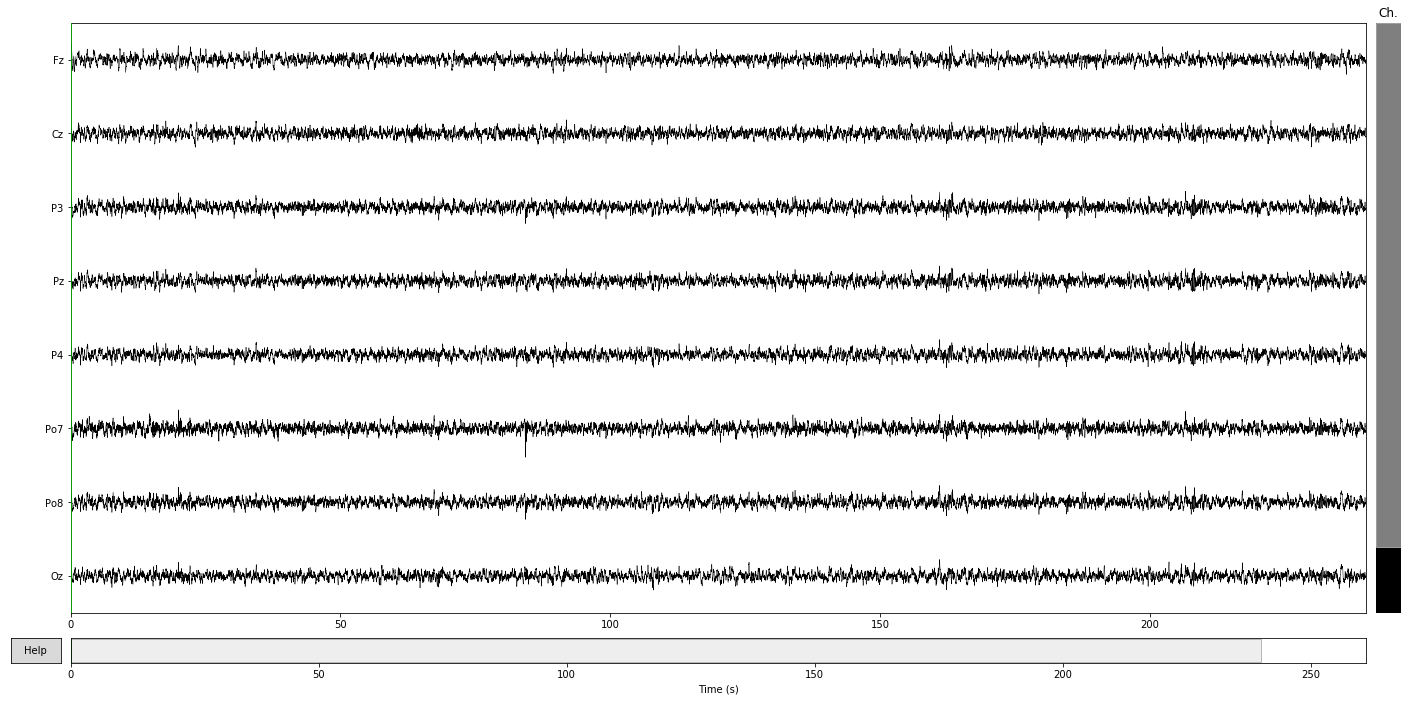

2700 events found
Event IDs: [1 2]
2700 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2700 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


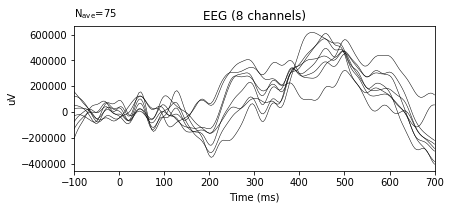

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


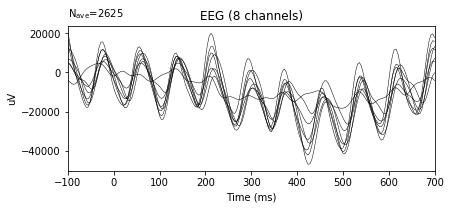

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


/home/noomkcalb/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/noomkcalb/.local/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - slidin

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epoc

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epoc

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epoc

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epoc

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)

Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


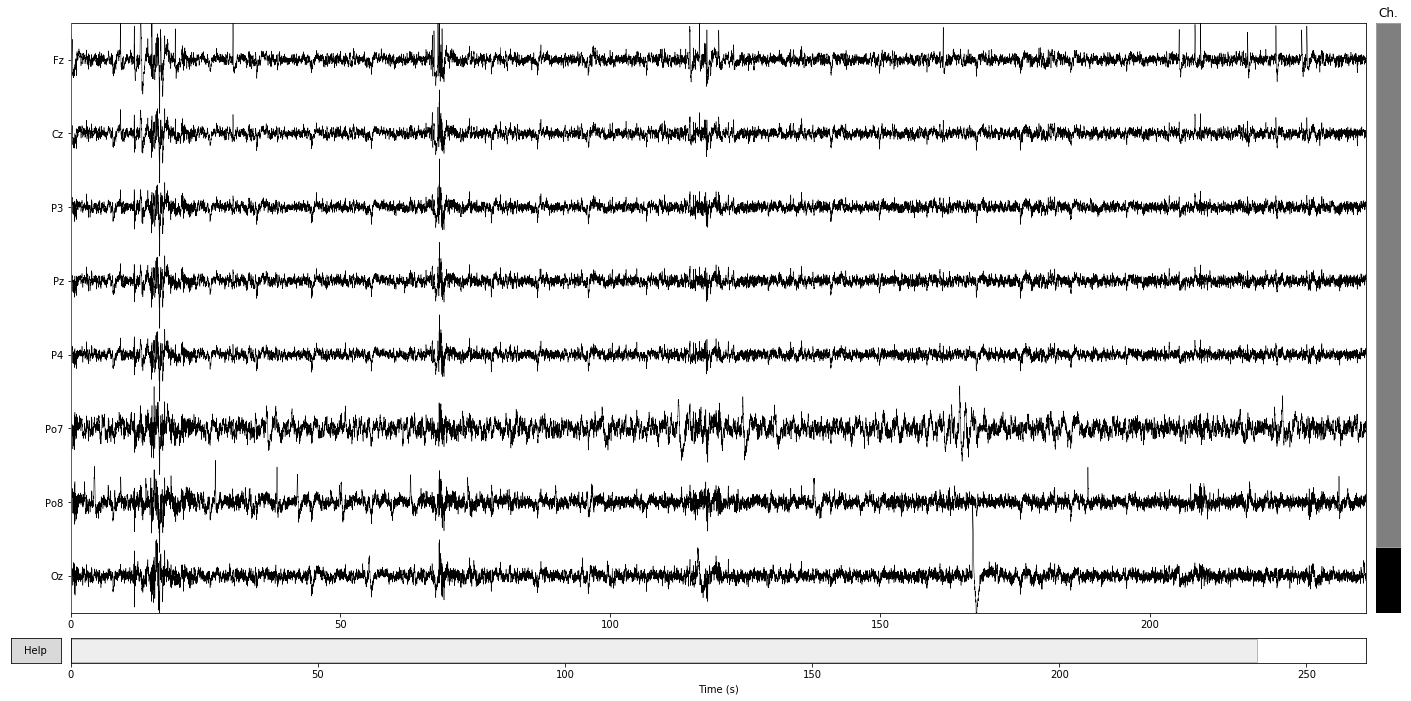

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.5s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.


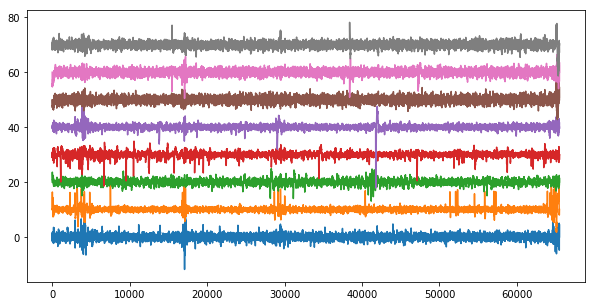

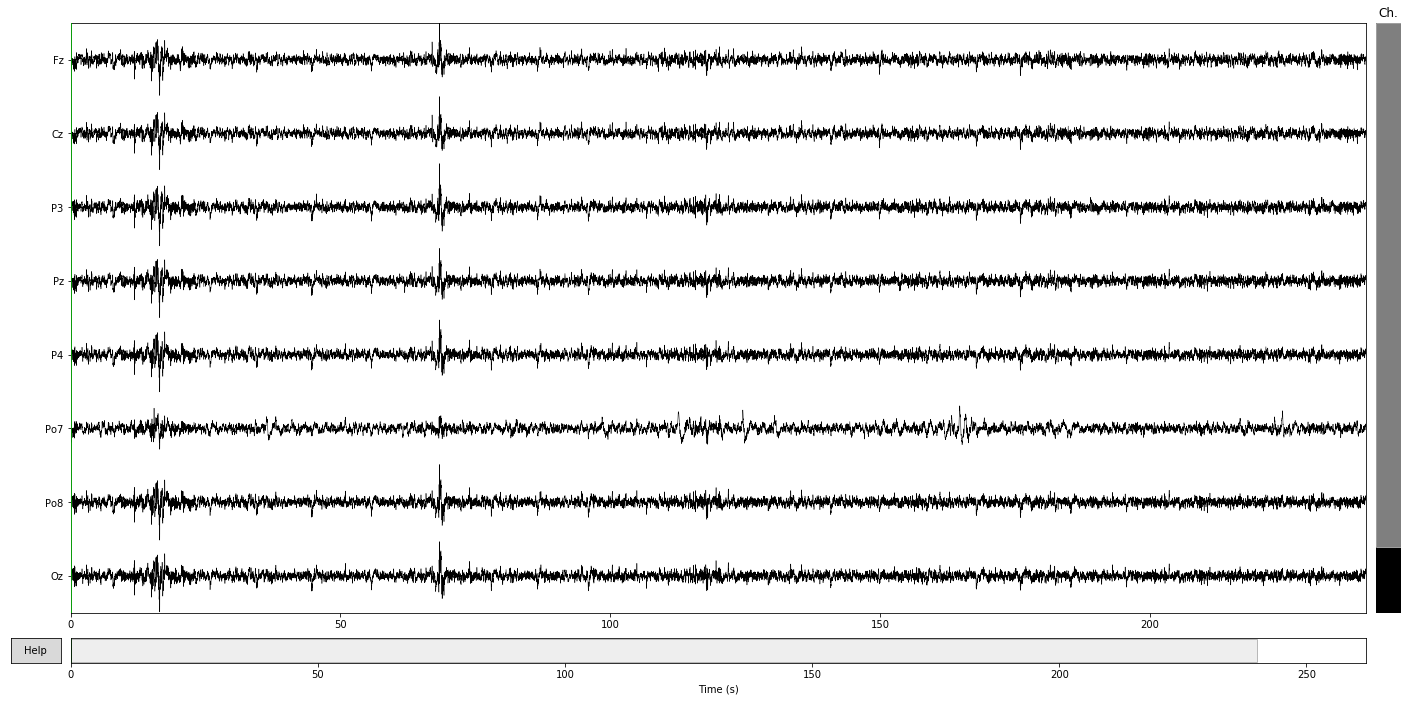

2700 events found
Event IDs: [1 2]
2700 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2700 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


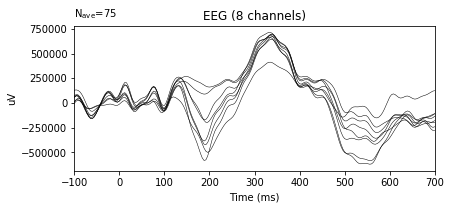

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


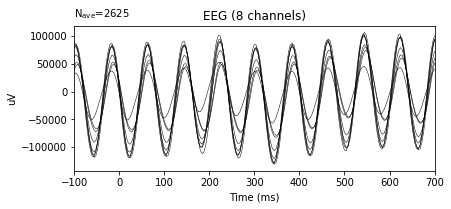

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


/home/noomkcalb/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/noomkcalb/.local/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - slidin

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epoc

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epoc

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epoc

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epoc

evoked object is empty (based on less than 1 epoch)
evoked object is empty (based on less than 1 epoch)

Creating RawArray with float64 data, n_channels=9, n_times=61866
    Range : 0 ... 61865 =      0.000 ...   247.460 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-103-866979fc6d3d>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  p300_matrix = epochs['1'][i - sliding_window_size:i].average().data
<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


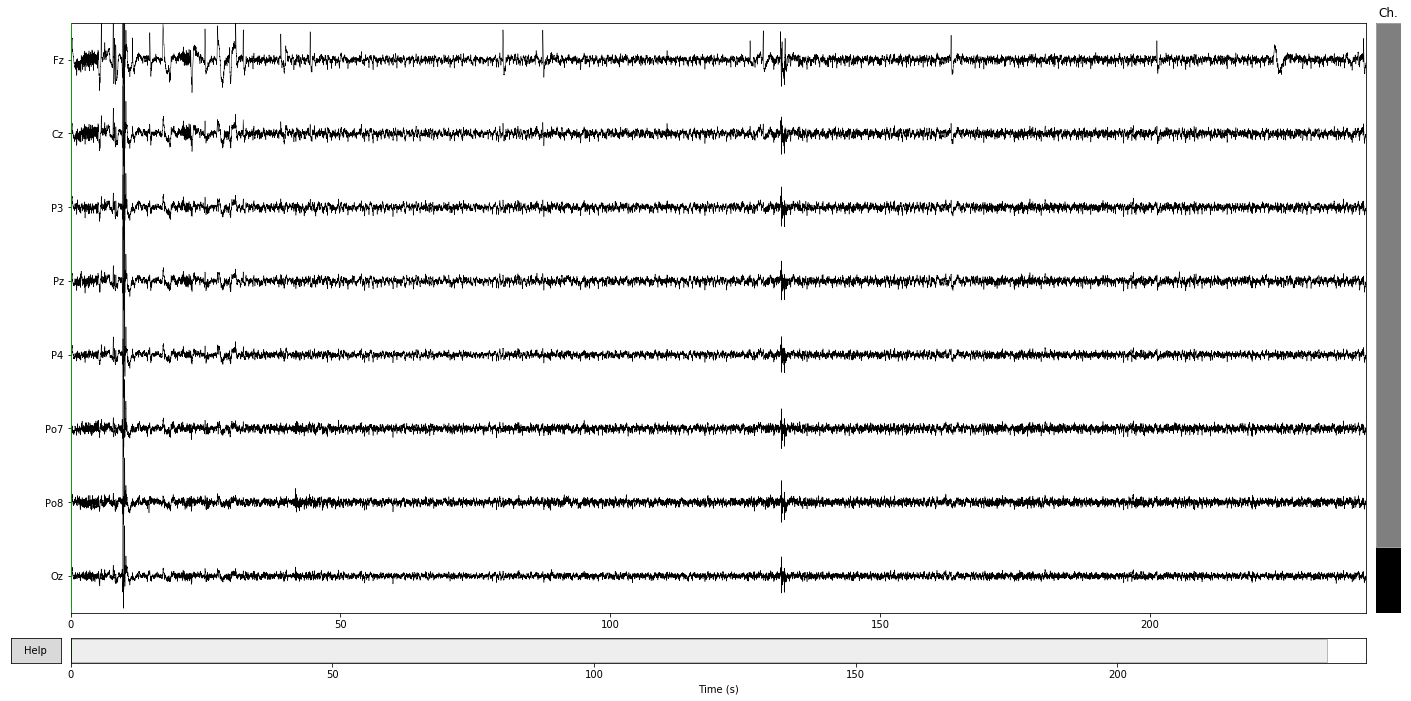

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.5s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=61866
    Range : 0 ... 61865 =      0.000 ...   247.460 secs
Ready.


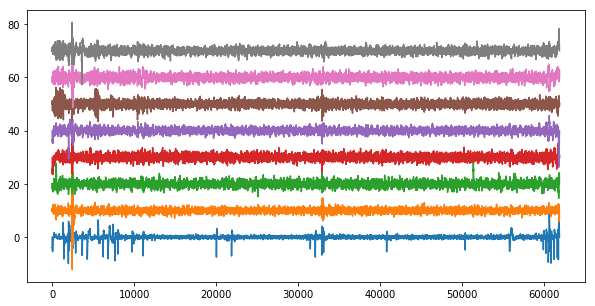

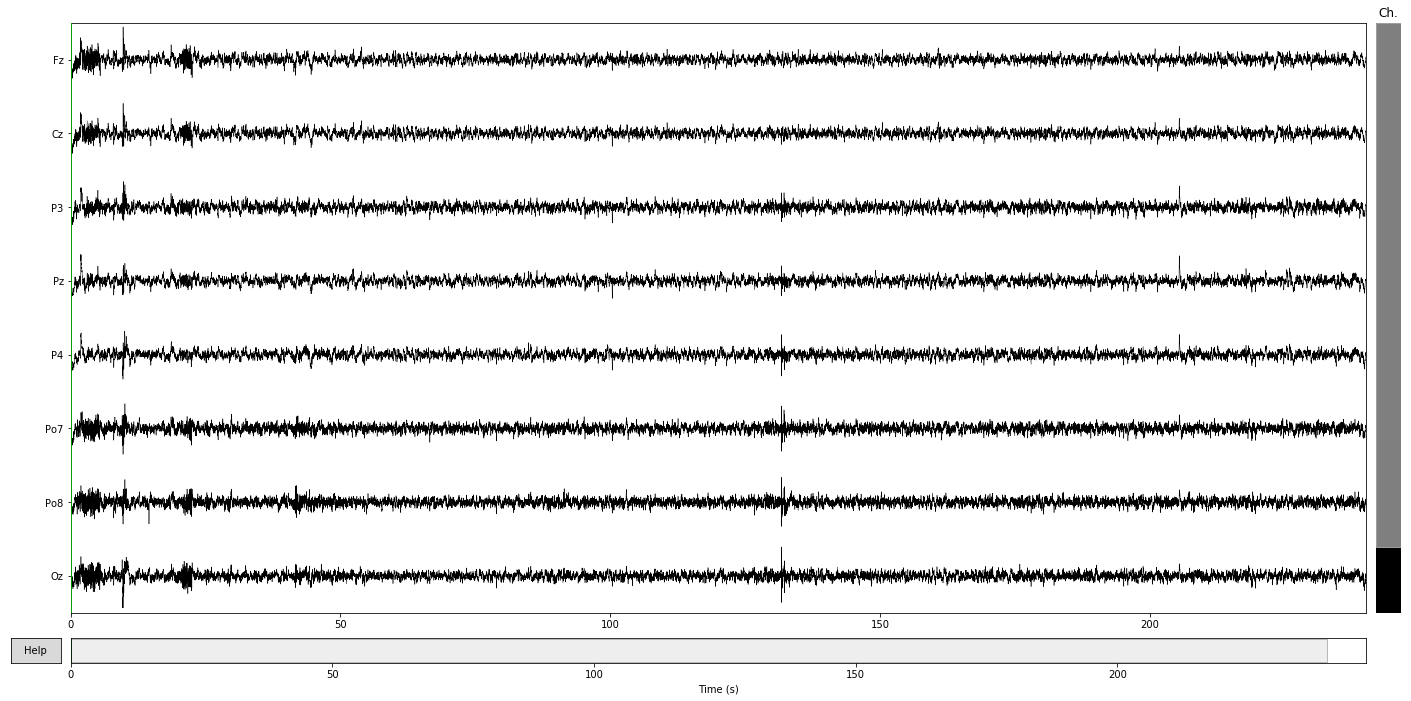

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


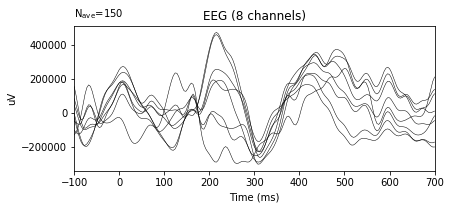

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


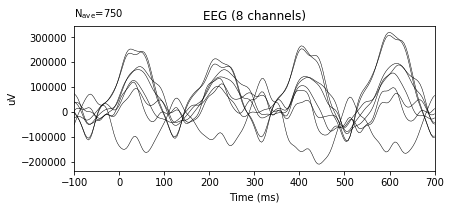


Creating RawArray with float64 data, n_channels=9, n_times=48901
    Range : 0 ... 48900 =      0.000 ...   195.600 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


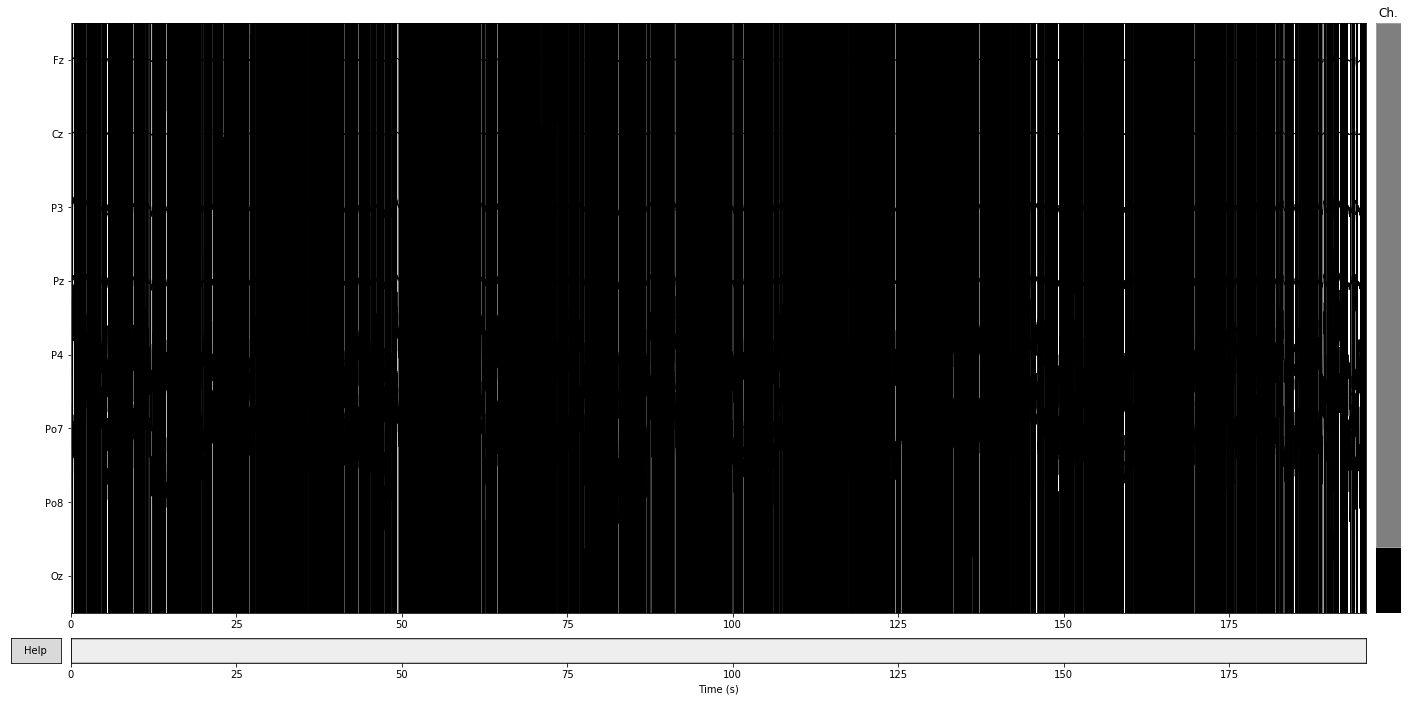

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.6s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=48901
    Range : 0 ... 48900 =      0.000 ...   195.600 secs
Ready.


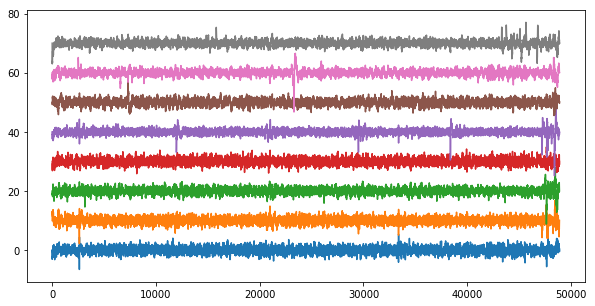

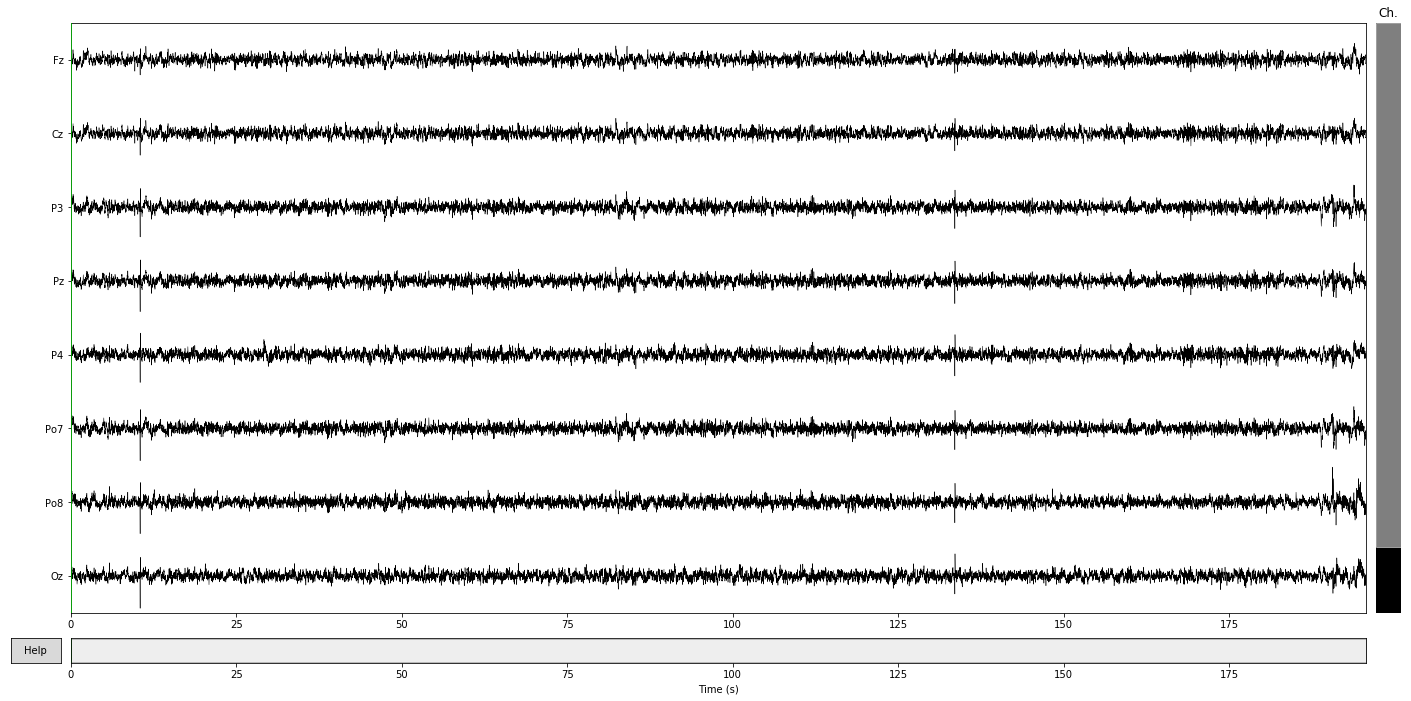

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


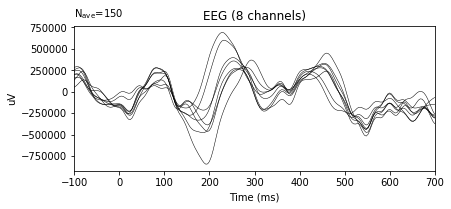

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


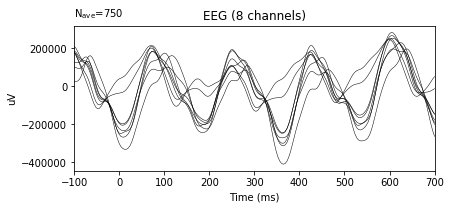


Creating RawArray with float64 data, n_channels=9, n_times=58682
    Range : 0 ... 58681 =      0.000 ...   234.724 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


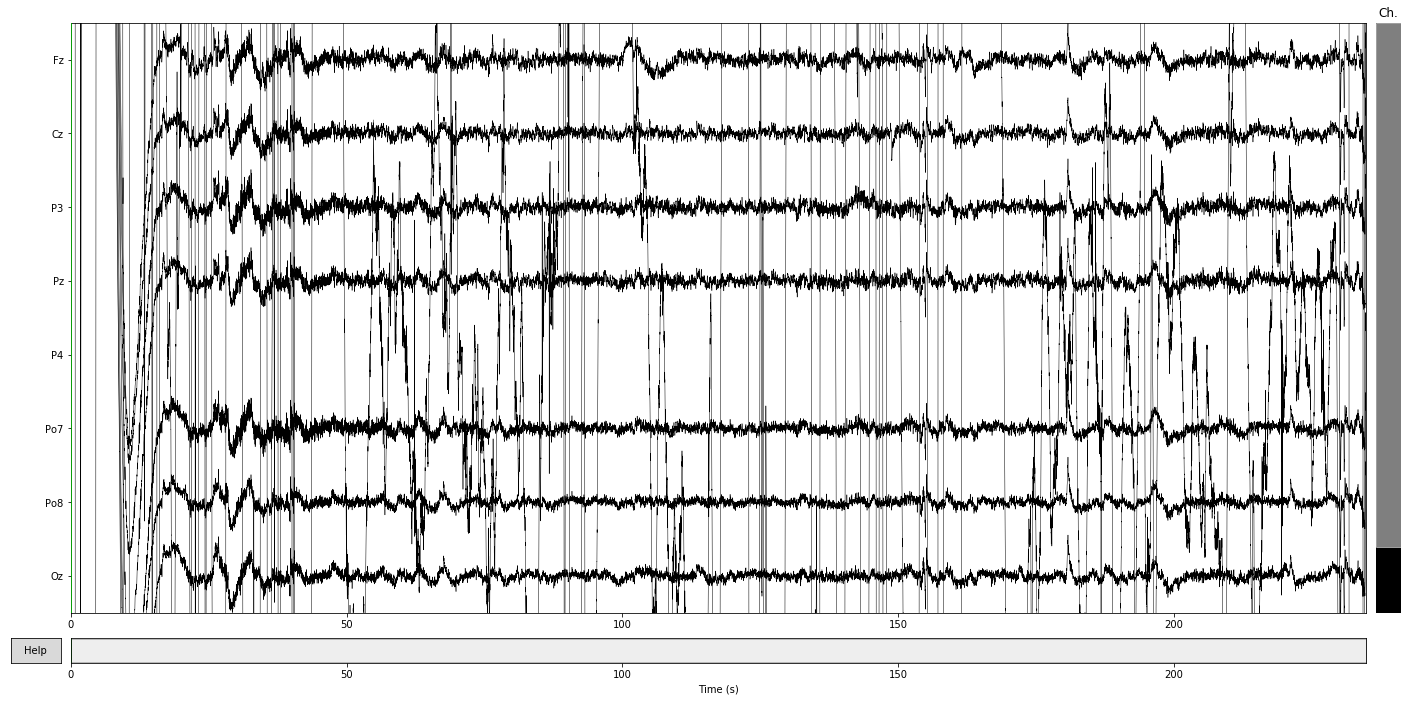

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.2s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=58682
    Range : 0 ... 58681 =      0.000 ...   234.724 secs
Ready.


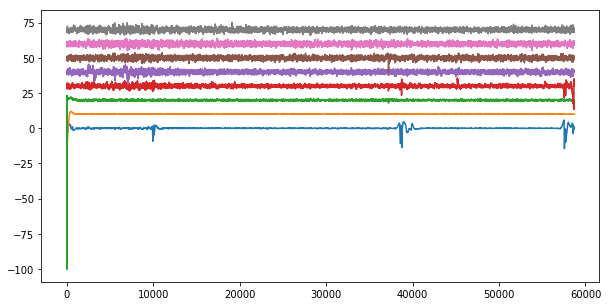

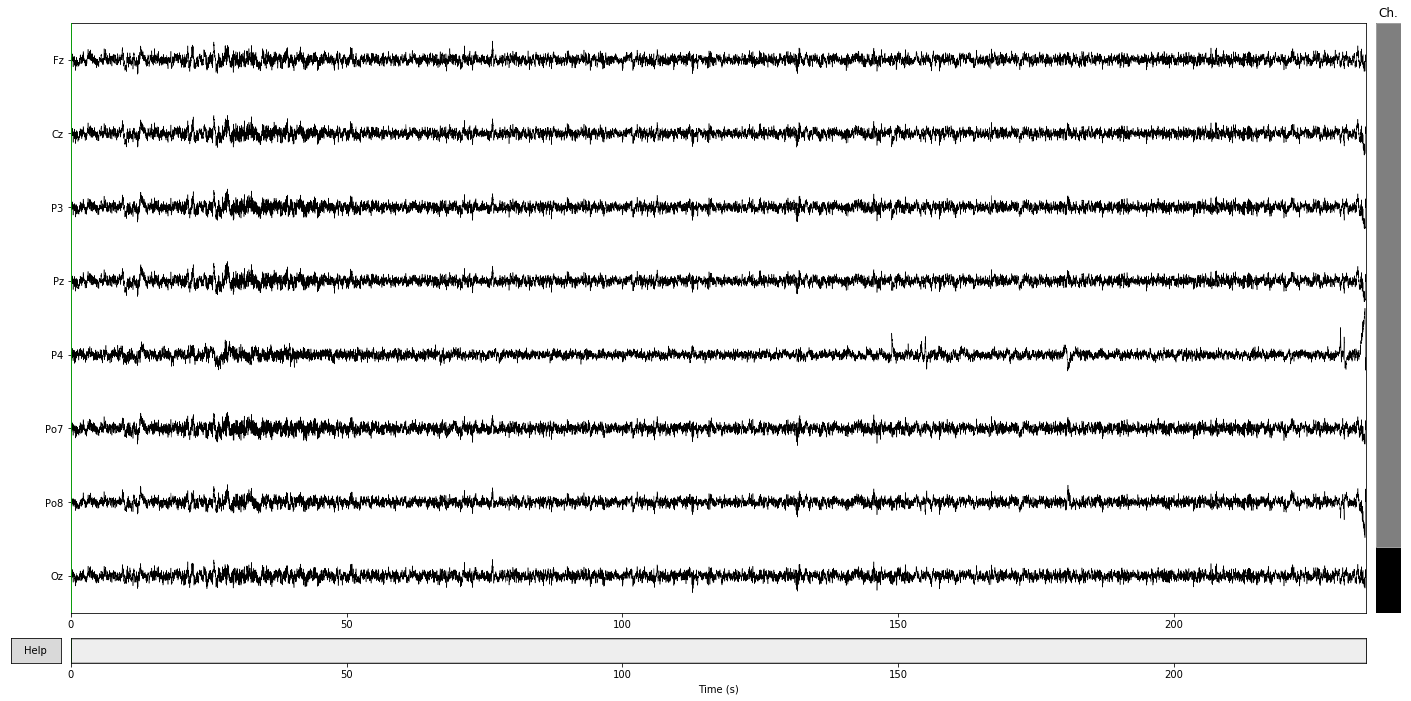

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


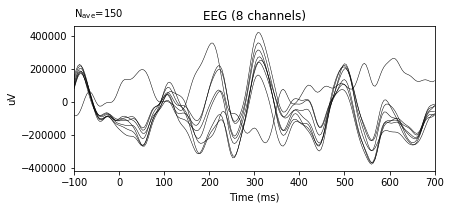

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


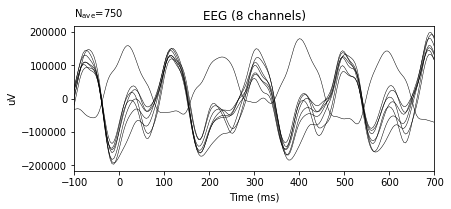


Creating RawArray with float64 data, n_channels=9, n_times=25327
    Range : 0 ... 25326 =      0.000 ...   101.304 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


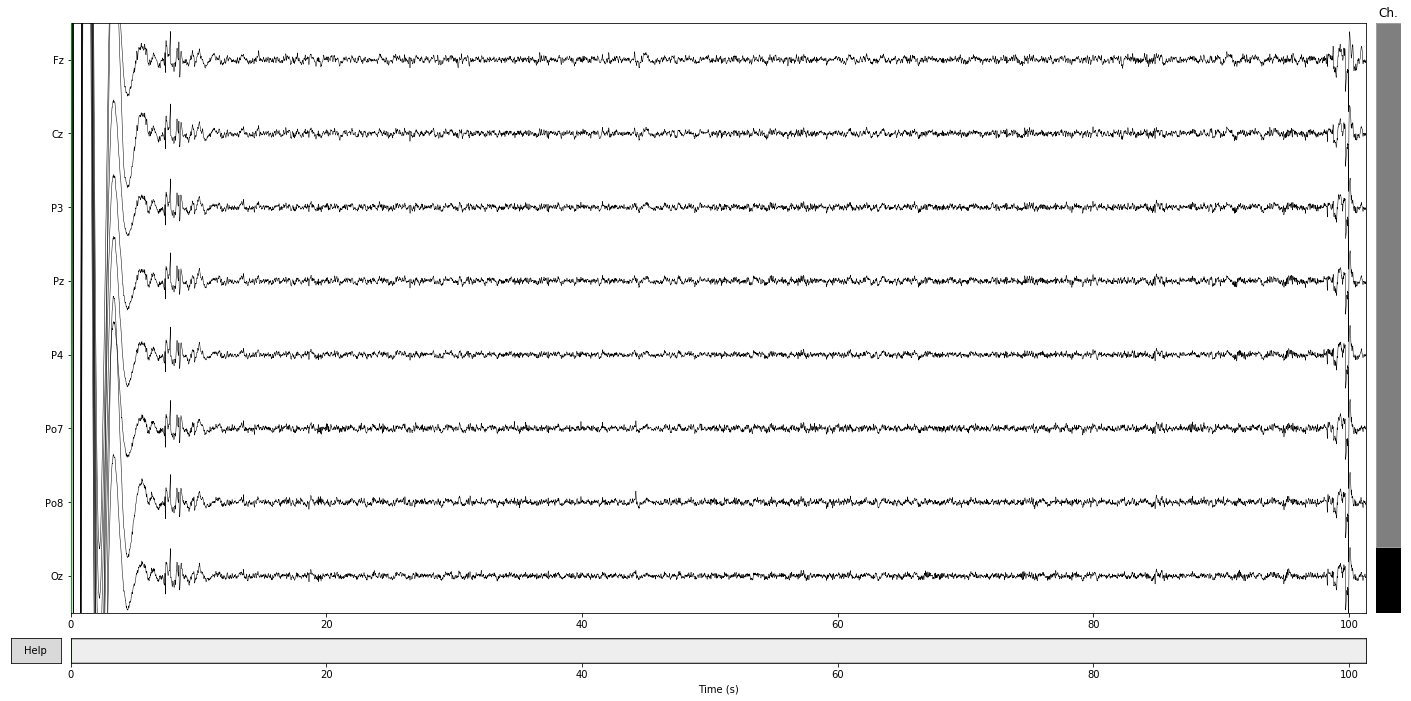

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.2s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=25327
    Range : 0 ... 25326 =      0.000 ...   101.304 secs
Ready.


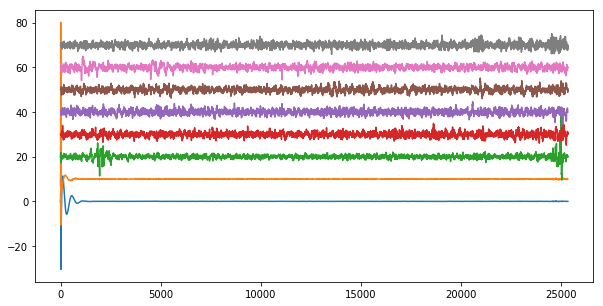

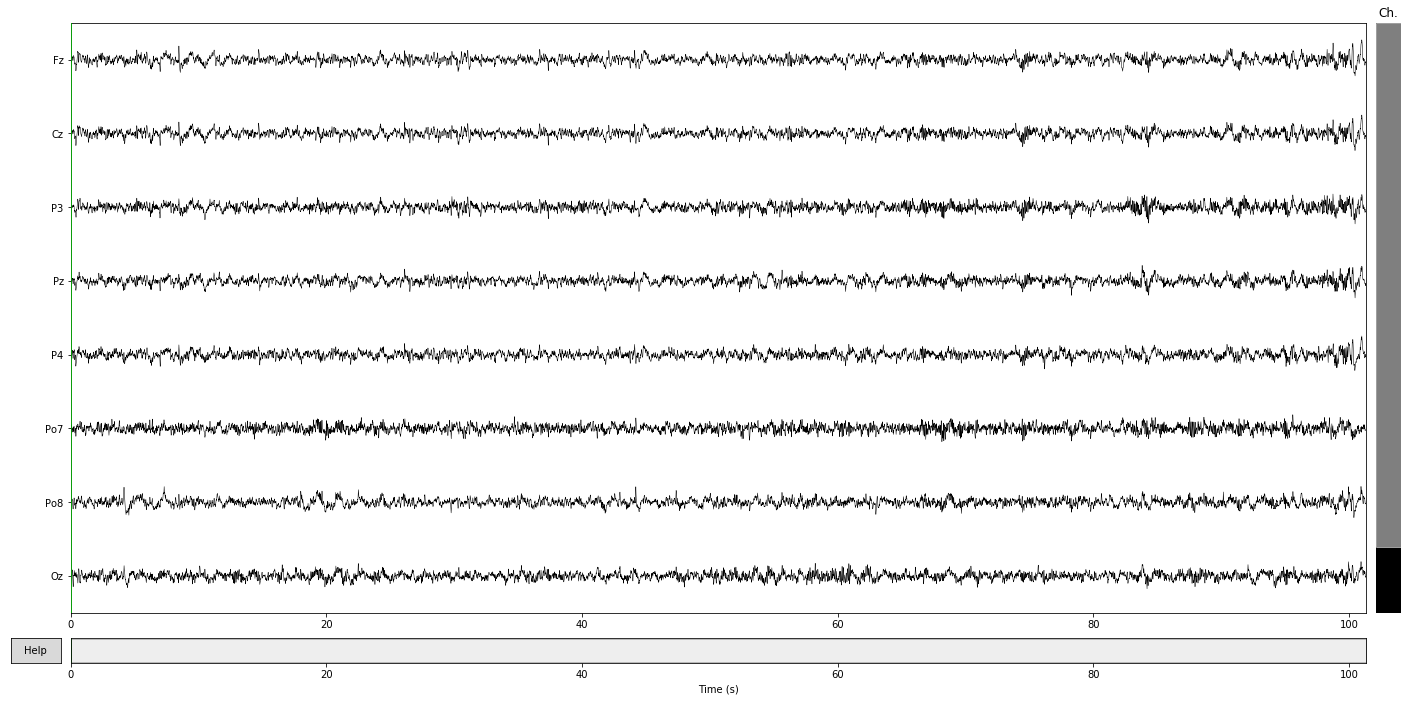

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


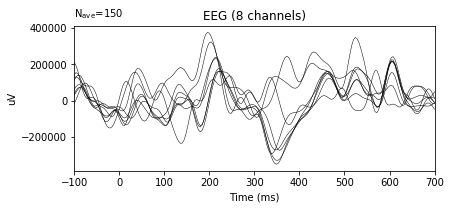

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


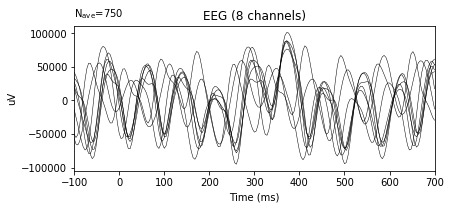


Creating RawArray with float64 data, n_channels=9, n_times=28806
    Range : 0 ... 28805 =      0.000 ...   115.220 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


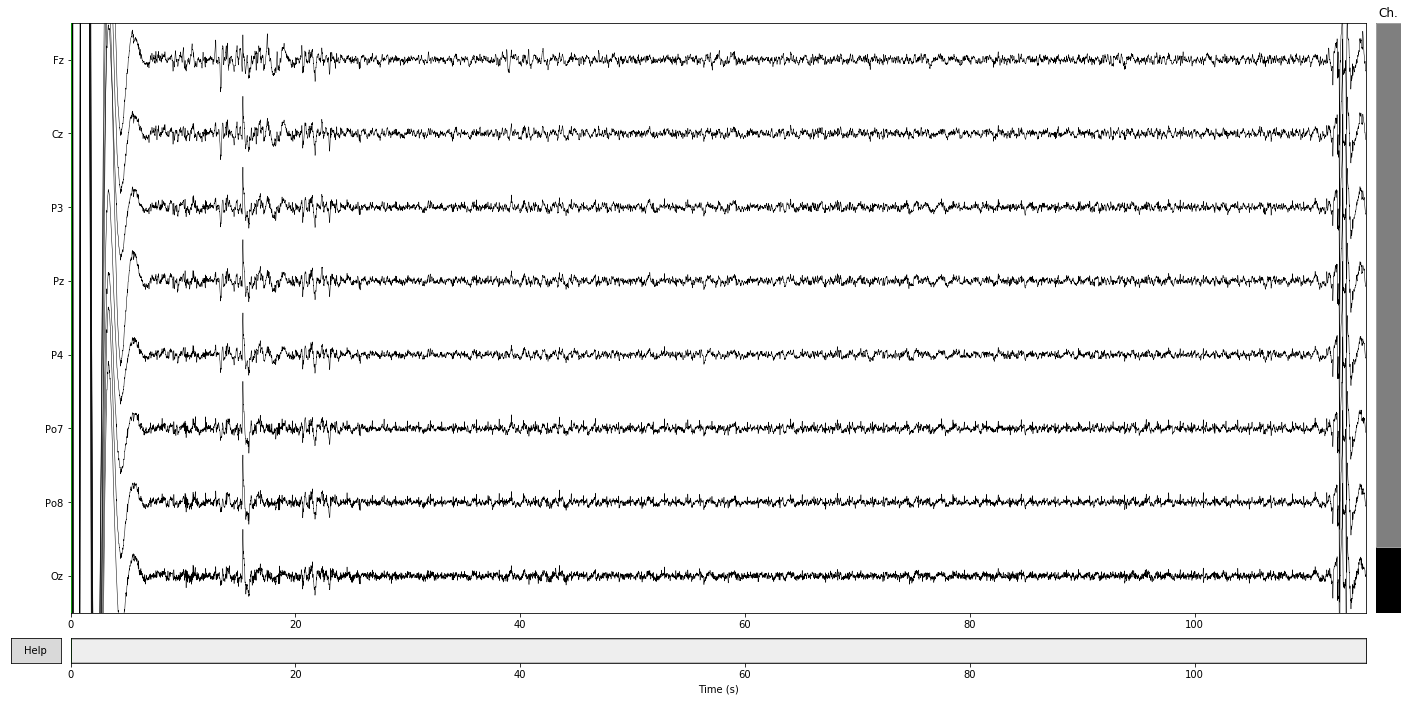

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.3s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=28806
    Range : 0 ... 28805 =      0.000 ...   115.220 secs
Ready.


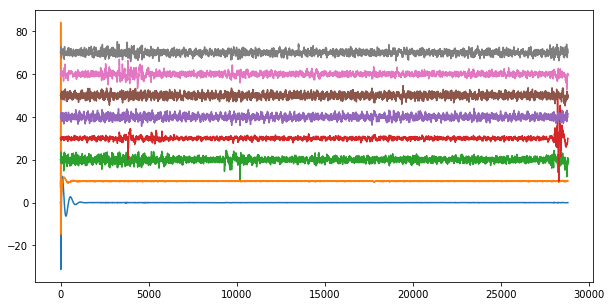

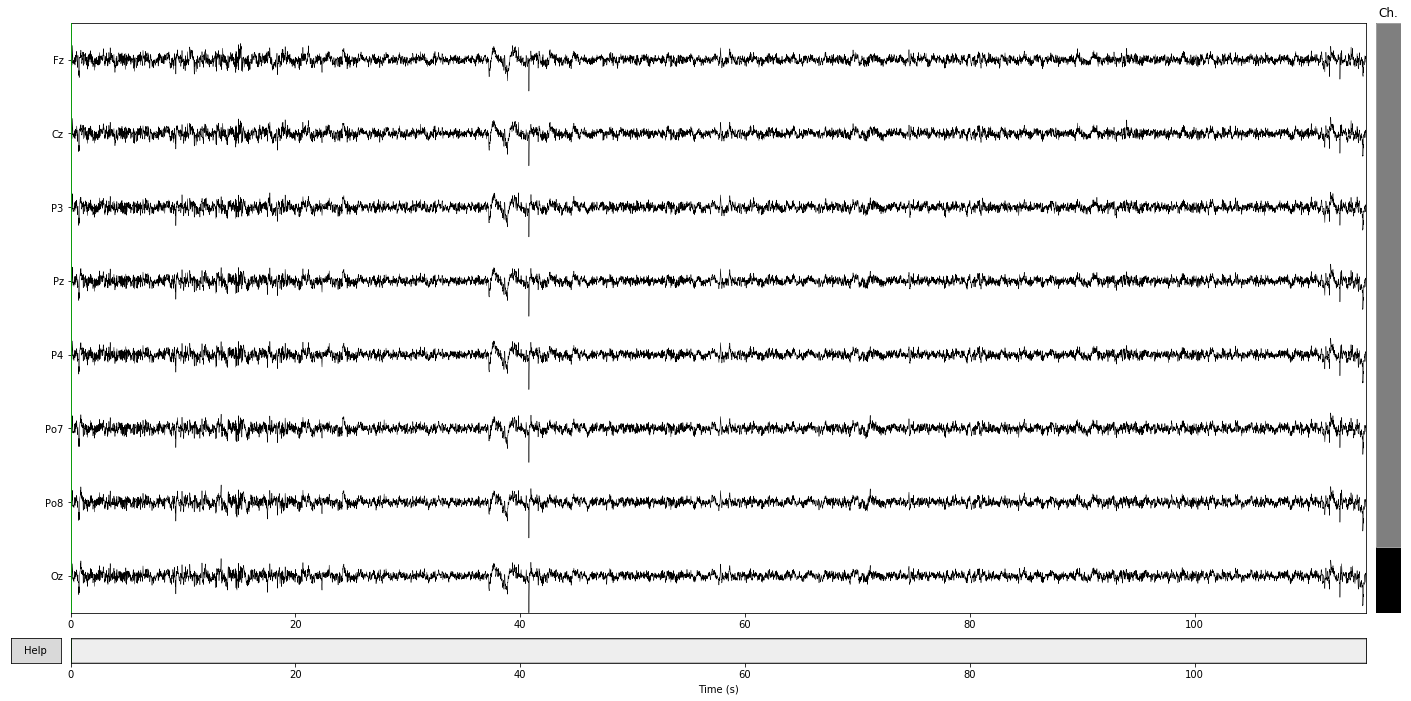

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


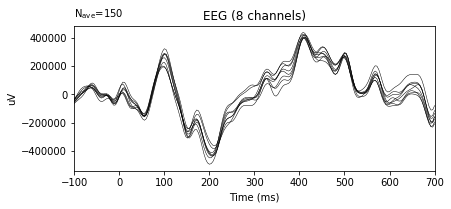

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


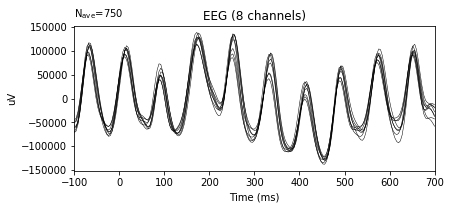


Creating RawArray with float64 data, n_channels=9, n_times=28901
    Range : 0 ... 28900 =      0.000 ...   115.600 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


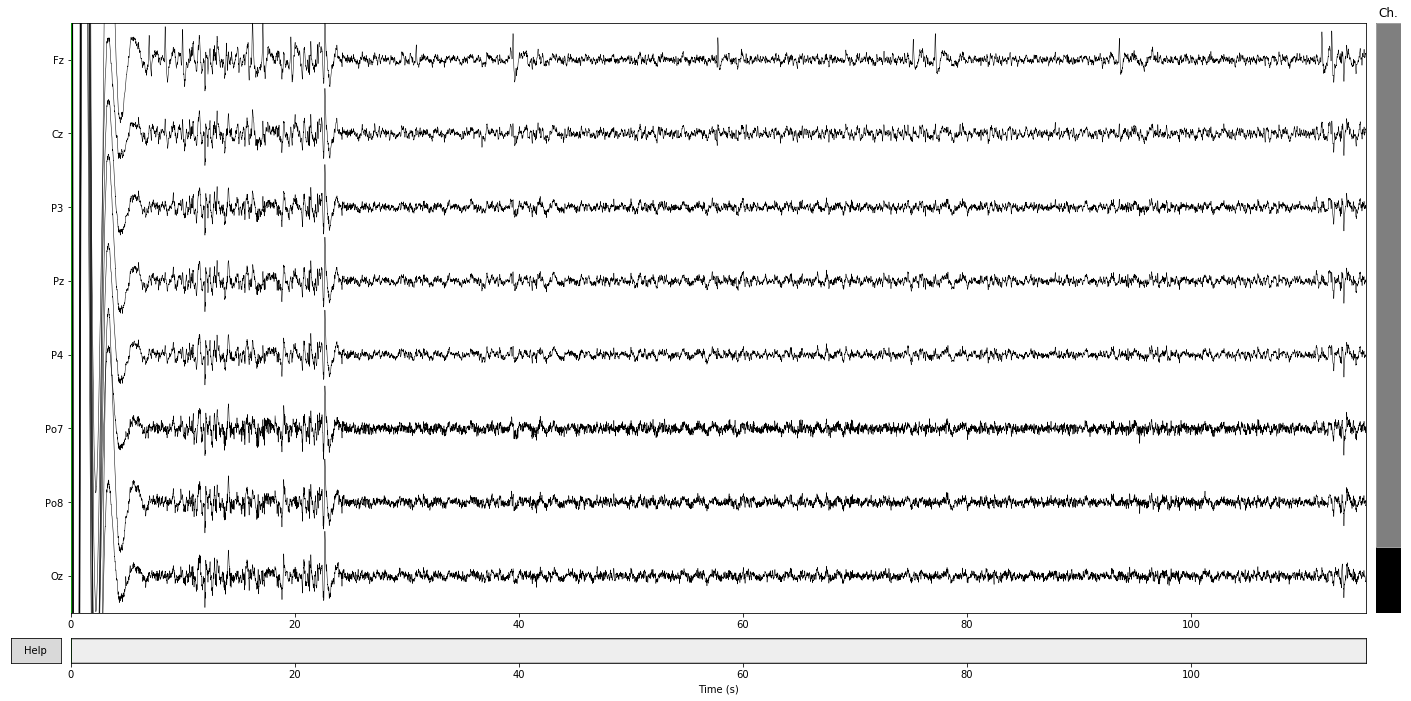

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.1s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=28901
    Range : 0 ... 28900 =      0.000 ...   115.600 secs
Ready.


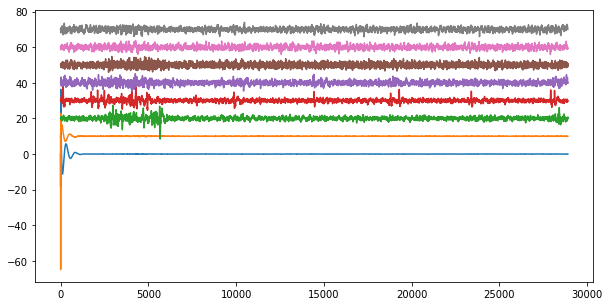

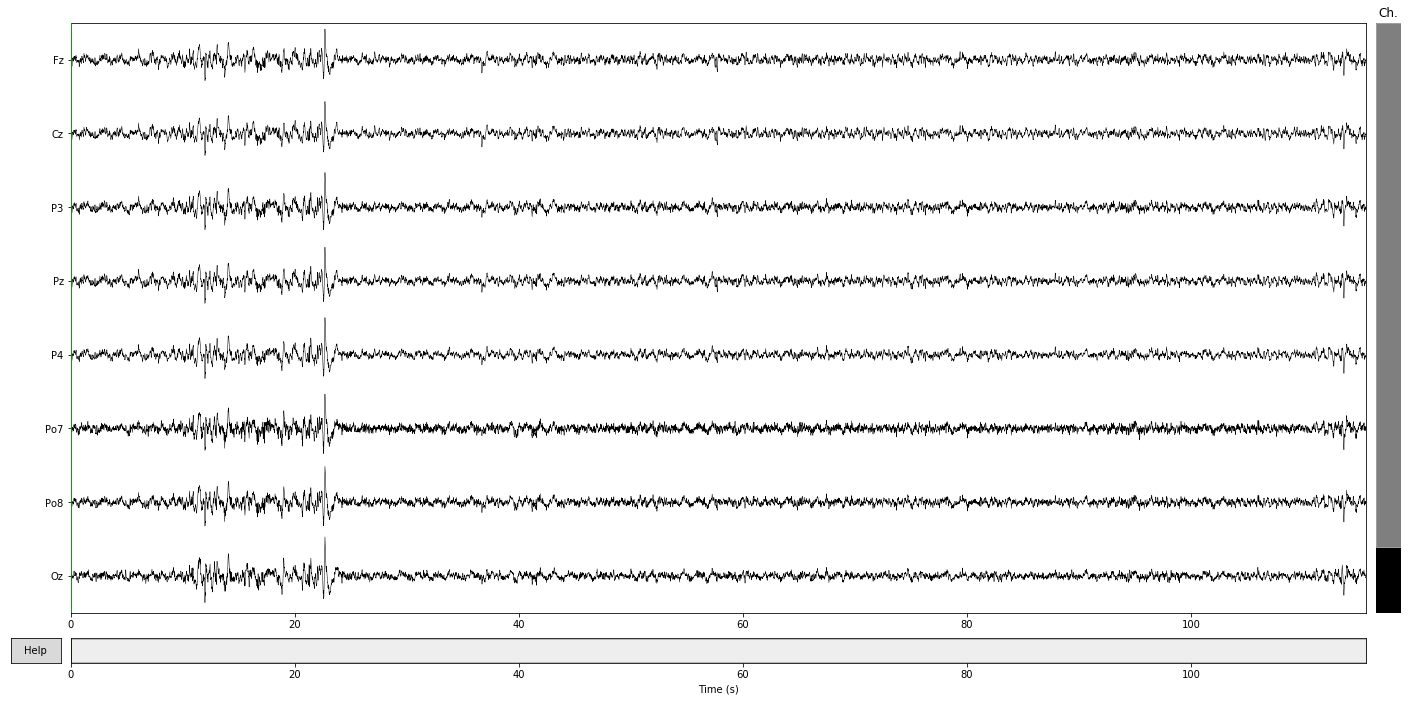

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


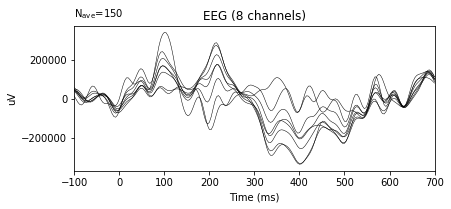

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


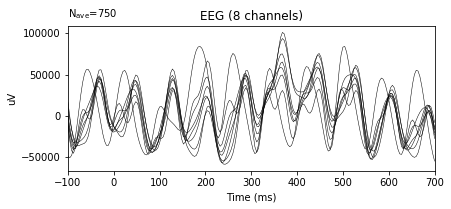


Creating RawArray with float64 data, n_channels=9, n_times=27940
    Range : 0 ... 27939 =      0.000 ...   111.756 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


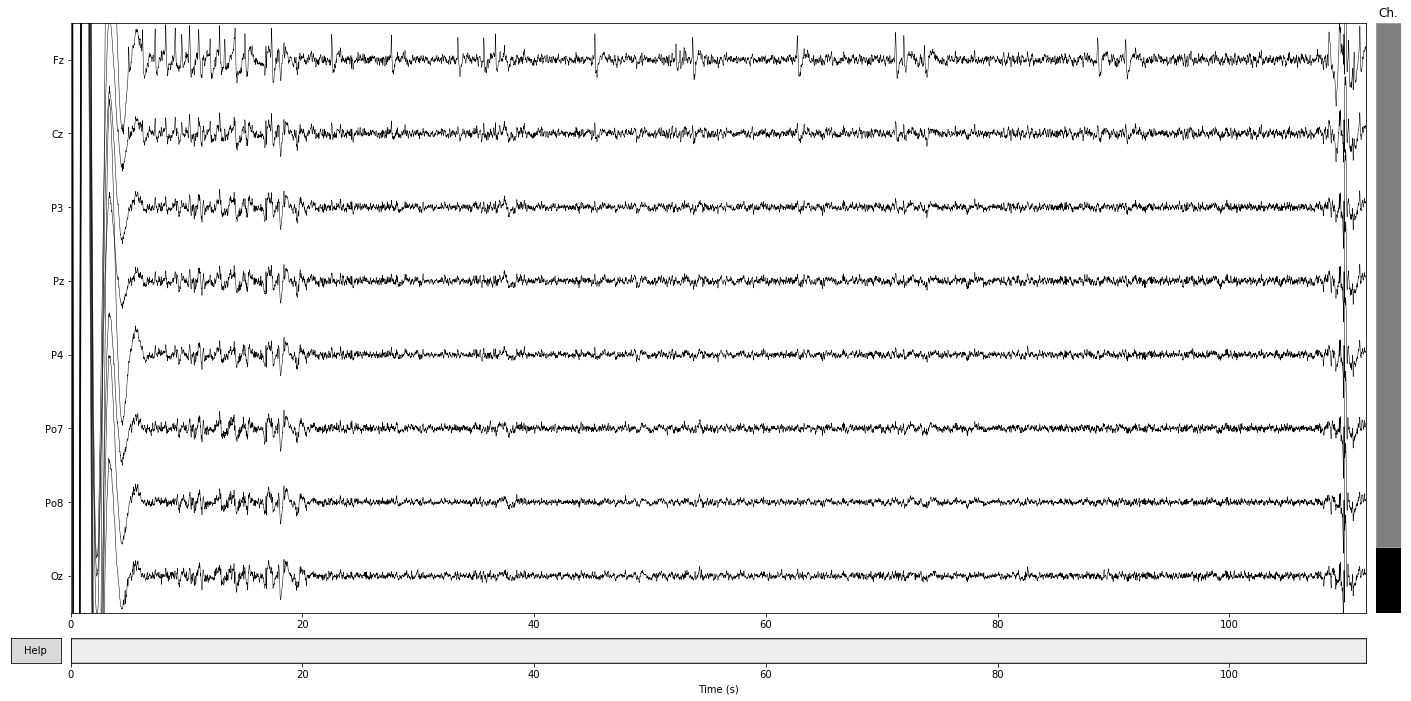

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.1s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=27940
    Range : 0 ... 27939 =      0.000 ...   111.756 secs
Ready.


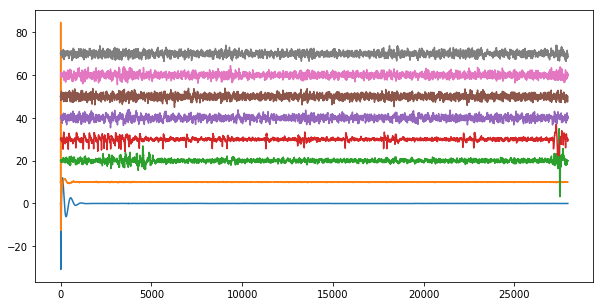

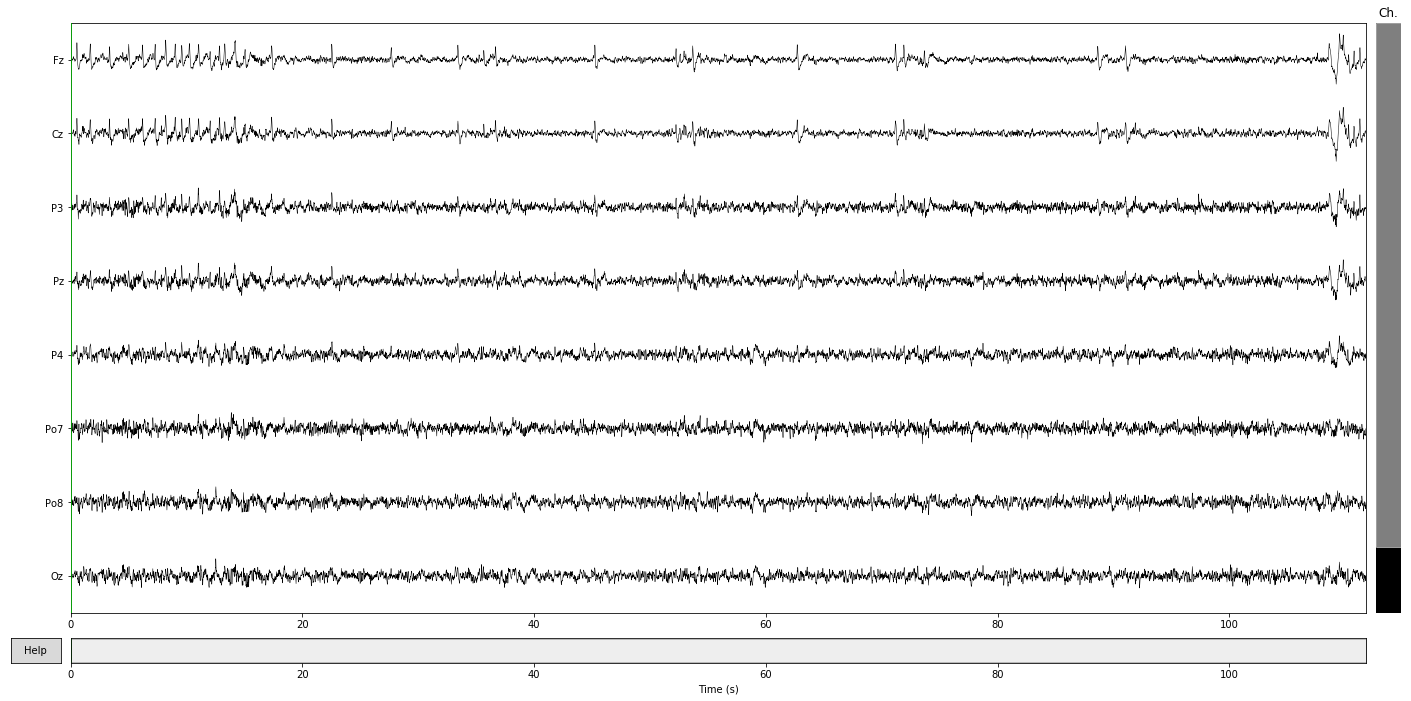

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


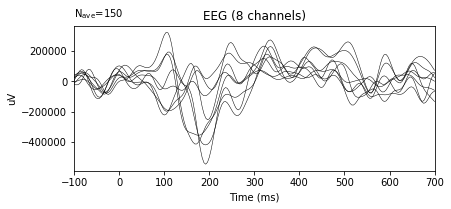

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


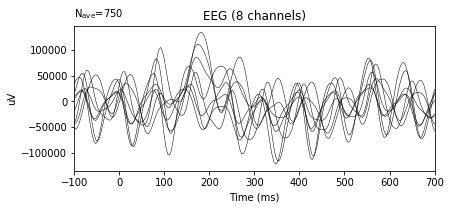


Creating RawArray with float64 data, n_channels=9, n_times=25587
    Range : 0 ... 25586 =      0.000 ...   102.344 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-27-90a5503e84bc>:10: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


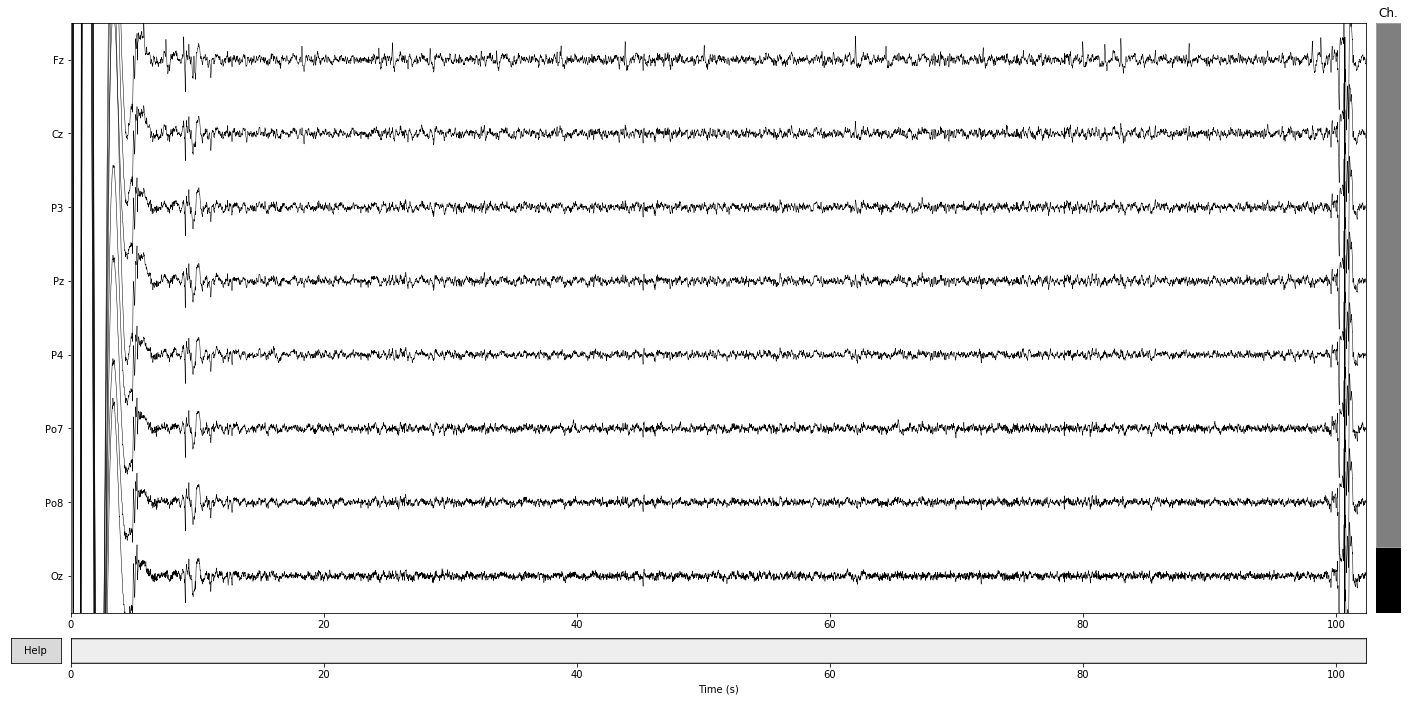

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.1s.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Creating RawArray with float64 data, n_channels=9, n_times=25587
    Range : 0 ... 25586 =      0.000 ...   102.344 secs
Ready.


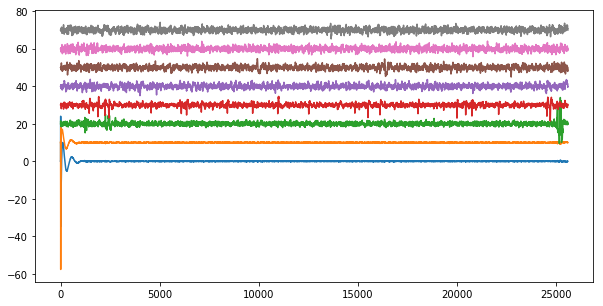

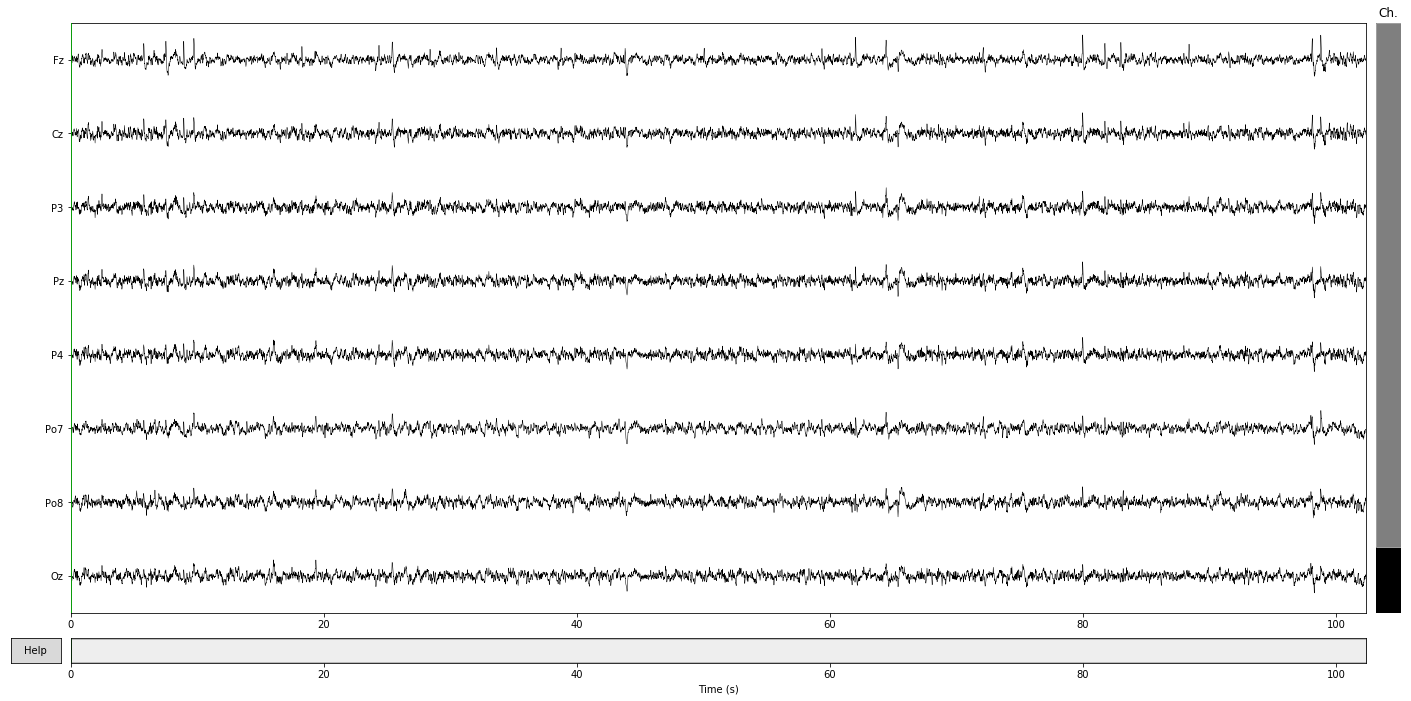

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


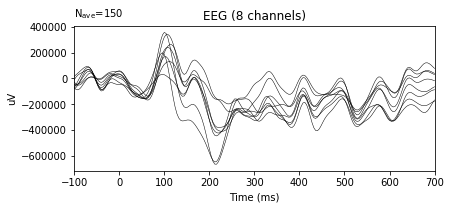

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-60-8cfcad17c42b>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


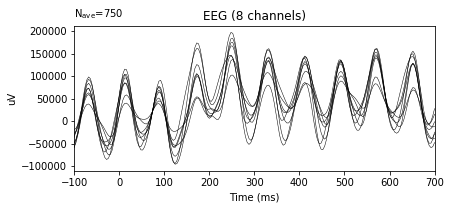

In [105]:
all_features = []

for i in range(1, 11):
    features = process_signal(i)
    all_features += features

# Visualization

In [106]:
all_features_df = pd.DataFrame(all_features, columns=["latency", "amplitude", "subject", "trial"])

In [107]:
all_features_df.head()

latency  amplitude subject  trial
0      304   0.039978      S1     10
1      372   0.222862      S1     11
2      308   0.133093      S1     12
3      344   0.070212      S1     13
4      304   0.163569      S1     14

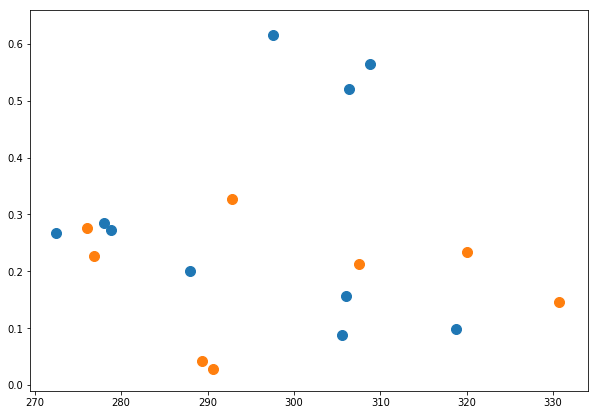

In [108]:
plt.figure(figsize=(10, 7))
features_df = all_features_df[all_features_df["trial"] < 20].groupby("subject").mean()
plt.scatter(features_df["latency"], features_df["amplitude"], s=100)

features_df = all_features_df[all_features_df["trial"] > 140].groupby("subject").mean()
plt.scatter(features_df["latency"], features_df["amplitude"], s=100)

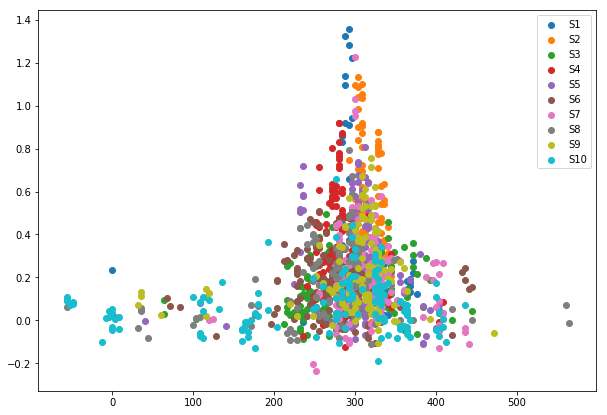

In [109]:
plt.figure(figsize=(10, 7))

for subject in all_features_df["subject"].unique():
    features_df = all_features_df[all_features_df["subject"] == subject]
    plt.scatter(features_df["latency"], features_df["amplitude"], label=subject)

plt.legend()
# plt.xlim(200, 410)